<center>

### CS-GY 9223: Intro To Responsible AI

### Fairness Audit of Student Performance Prediction Model
</center>

<center>

Laxman Singh Rawat      |       Nikhil Mahana       |       Yathin Reddy Duvuru

</center>

## Background

This project aims to audit the fairness of the Student Performance Prediction Model. This work builds upon the analysis of a dataset concerning the performance of students from two Portuguese secondary schools, originally conducted by Mohamed Salah Ibrahim, a Data Scientist & AI Engineer [3].

In his work, Ibrahim developed a predictive model that estimates a student's final grade based on various factors, including demographics, parental education, study time, travel time, and family relationships. While his study covers data exploration, feature preprocessing, and model evaluation, it does not assess the model's fairness regarding sensitive features such as age, sex, parental education, and profession.

This project aims to conduct these fairness analyses and identify the potential impacts of using such an Automated Decision System (ADS) to score students, drawing parallels to the controversy surrounding the UK's grading algorithm during the COVID-19 pandemic in 2020 [2]. We will measure key bias metrics—such as demographic parity, equalized odds, and predictive parity—across these sensitive attributes. Our goal is to understand the trade-offs between different fairness definitions and assess whether algorithmic retraining or threshold adjustment can mitigate bias without significantly reducing predictive accuracy.

## Input

#### Dataoverview

The data used in this project is downloaded from UC Irvine's Machine Learning Repository [4] and holds information about student in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social and school related features and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por).[1]

The dataset contains information on students’ demographic and academic attributes such as:
- Student demographics (`sex`, `age`, `address`)
- Parental education levels (`Medu`, `Fedu`)  
- Study and travel times (`studytime`, `traveltime`)  
- Family and social relationships (`Pstatus`, `famrel`, `goout`, `romantic`)  
- Academic performance indicators (`G1`, `G2`, `failures`, `activities`)  
- Lifestyle factors (`Dalc`, `Walc`, `health`, `absences`)

Following is the table containing all the attributes with their description and data type.

| Attribute | Description | Domain |
|-----------|-------------|---------|
| **sex** | Student's sex | Binary: female or male |
| **age** | Student's age | Numeric: from 15 to 22 |
| **school** | Student's school | Binary: Gabriel Pereira or Mousinho da Silveira |
| **address** | Student's home address type | Binary: urban or rural |
| **Pstatus** | Parent's cohabitation status | Binary: living together or apart |
| **Medu** | Mother's education | Numeric: from 0 to 4ᵃ |
| **Mjob** | Mother's job | Nominalᵇ |
| **Fedu** | Father's education | Numeric: from 0 to 4ᵃ |
| **Fjob** | Father's job | Nominalᵇ |
| **guardian** | Student's guardian | Nominal: mother, father or other |
| **famsize** | Family size | Binary: ≤ 3 or > 3 |
| **famrel** | Quality of family relationships | Numeric: from 1 (very bad) to 5 (excellent) |
| **reason** | Reason to choose this school | Nominal: close to home, school reputation, course preference or other |
| **traveltime** | Home to school travel time | Numeric: 1 (< 15 min.), 2 (15 to 30 min.), 3 (30 min. to 1 hour) or 4 (> 1 hour) |
| **studytime** | Weekly study time | Numeric: 1 (< 2 hours), 2 (2 to 5 hours), 3 (5 to 10 hours) or 4 (> 10 hours) |
| **failures** | Number of past class failures | Numeric: n if 1 ≤ n < 3, else 4 |
| **schoolsup** | Extra educational school support | Binary: yes or no |
| **famsup** | Family educational support | Binary: yes or no |
| **activities** | Extra-curricular activities | Binary: yes or no |
| **paidclass** | Extra paid classes | Binary: yes or no |
| **internet** | Internet access at home | Binary: yes or no |
| **nursery** | Attended nursery school | Binary: yes or no |
| **higher** | Wants to take higher education | Binary: yes or no |
| **romantic** | With a romantic relationship | Binary: yes or no |
| **freetime** | Free time after school | Numeric: from 1 (very low) to 5 (very high) |
| **goout** | Going out with friends | Numeric: from 1 (very low) to 5 (very high) |
| **Walc** | Weekend alcohol consumption | Numeric: from 1 (very low) to 5 (very high) |
| **Dalc** | Workday alcohol consumption | Numeric: from 1 (very low) to 5 (very high) |
| **health** | Current health status | Numeric: from 1 (very bad) to 5 (very good) |
| **absences** | Number of school absences | Numeric: from 0 to 93 |
| **G1** | First period grade | Numeric: from 0 to 20 |
| **G2** | Second period grade | Numeric: from 0 to 20 |
| **G3** | Final grade | Numeric: from 0 to 20 |

**Notes:**
- ᵃ Education levels: 0 (none), 1 (primary education - 4th grade), 2 (5th to 9th grade), 3 (secondary education), 4 (higher education)
- ᵇ Nominal job categories include: teacher, health care related, civil services, at_home, or other

### Data Profiling

#### Import Libraries and Dependencies

In [45]:
# Data manipulation and numerical computing
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations in Python
import matplotlib.ticker as ticker  # For formatting the ticks on the axes of plots
import seaborn as sn  # For statistical data visualization based on matplotlib
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computing and handling arrays

# Machine learning - model training and evaluation
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler  # For standardizing features by removing the mean and scaling to unit variance
from sklearn.linear_model import LogisticRegression  # For logistic regression modeling
import sklearn.metrics as skm  # For evaluating the performance of machine learning models
from sklearn.model_selection import cross_val_score  # For cross-validation of models

# Fairness evaluation metrics
from fairlearn.metrics import MetricFrame  # For creating a frame of metrics for fairness evaluation
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, selection_rate  # For measuring demographic parity
from fairlearn.metrics import false_negative_rate, false_positive_rate  # For measuring false negative and positive rates

# Data fetching and utilities
from ucimlrepo import fetch_ucirepo  # For accessing datasets from the UCI Machine Learning Repository
from IPython.display import clear_output  # For clearing the output of the current cell

# Disable warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import math

#### Fetch Dataset from UCI Repository

In [46]:
# Fetch the student performance dataset from UCI ML Repository
student_performance = fetch_ucirepo(id=320) 
  
# Separate features (X) and targets (y) as pandas dataframes 
X = student_performance.data.features 
y = student_performance.data.targets 

# Combine features and targets into a single dataframe for comprehensive analysis
full_df = X.join(y, how='outer')
full_df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


#### Dataset Shape and Structure

In [47]:
# Display dimensions of the dataset
full_df.shape

(649, 33)

#### Checking for NULLs and Data Types

In [48]:
# Check for missing values and data types in the dataset
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

There are a total of 649 records and 32 columns in the table. All the columns already have data in categorical or numberical values and there no nulls present that needs to be imputated. 

#### Identify Numeric and Categorical Columns

In [ ]:
# Separate columns by data type for appropriate processing
num_cols = full_df.select_dtypes(include='int64').columns
cat_cols = full_df.select_dtypes(include='object').columns
print(f'Numerical columns: {num_cols}')
print(f'Categorical columns: {cat_cols}')


Numerical columns: Index(['age', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')
Categorical columns: Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic'],
      dtype='object')


#### Map Categorical Variables to Meaningful Labels

In [51]:
# Define mappings for categorical and ordinal variables to human-readable format
edu_map = {
    0: "none",
    1: "primary (4th grade)",
    2: "5th to 9th grade",
    3: "secondary",
    4: "higher education"
}

traveltime_map = {
    1: "<15 min",
    2: "15–30 min",
    3: "30 min–1 hour",
    4: ">1 hour"
}

studytime_map = {
    1: "<2 hours",
    2: "2–5 hours",
    3: "5–10 hours",
    4: ">10 hours"
}

school_map = {
    'GP': 'Gabriel Pereira',
    'MS': 'Mousinho da Silveira'
}

address_map = {
    'U': 'urban',
    'R': 'rural'
}

famsize_map = {
    'GT3': 'greater than 3',
    'LE3': 'less or equal to 3'
}

Pstatus_map = {'T': 'living together',
               'A': 'apart'
}

# Apply mappings to transform categorical columns
full_df["Medu"] = full_df["Medu"].map(edu_map)
full_df["Fedu"] = full_df["Fedu"].map(edu_map)
full_df["traveltime"] = full_df["traveltime"].map(traveltime_map)
full_df["studytime"] = full_df["studytime"].map(studytime_map)
full_df['school'] = full_df['school'].map(school_map)
full_df['address'] = full_df['address'].map(address_map)
full_df['famsize'] = full_df['famsize'].map(famsize_map)
full_df['Pstatus'] = full_df['Pstatus'].map(Pstatus_map)

# Display transformed categorical data
full_df[cat_cols].head()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,Gabriel Pereira,F,urban,greater than 3,apart,at_home,teacher,course,mother,yes,no,no,no,yes,yes,no,no
1,Gabriel Pereira,F,urban,greater than 3,living together,at_home,other,course,father,no,yes,no,no,no,yes,yes,no
2,Gabriel Pereira,F,urban,less or equal to 3,living together,at_home,other,other,mother,yes,no,no,no,yes,yes,yes,no
3,Gabriel Pereira,F,urban,greater than 3,living together,health,services,home,mother,no,yes,no,yes,yes,yes,yes,yes
4,Gabriel Pereira,F,urban,greater than 3,living together,other,other,home,father,no,yes,no,no,yes,yes,no,no


#### Analyzing Categorical Features Distribution

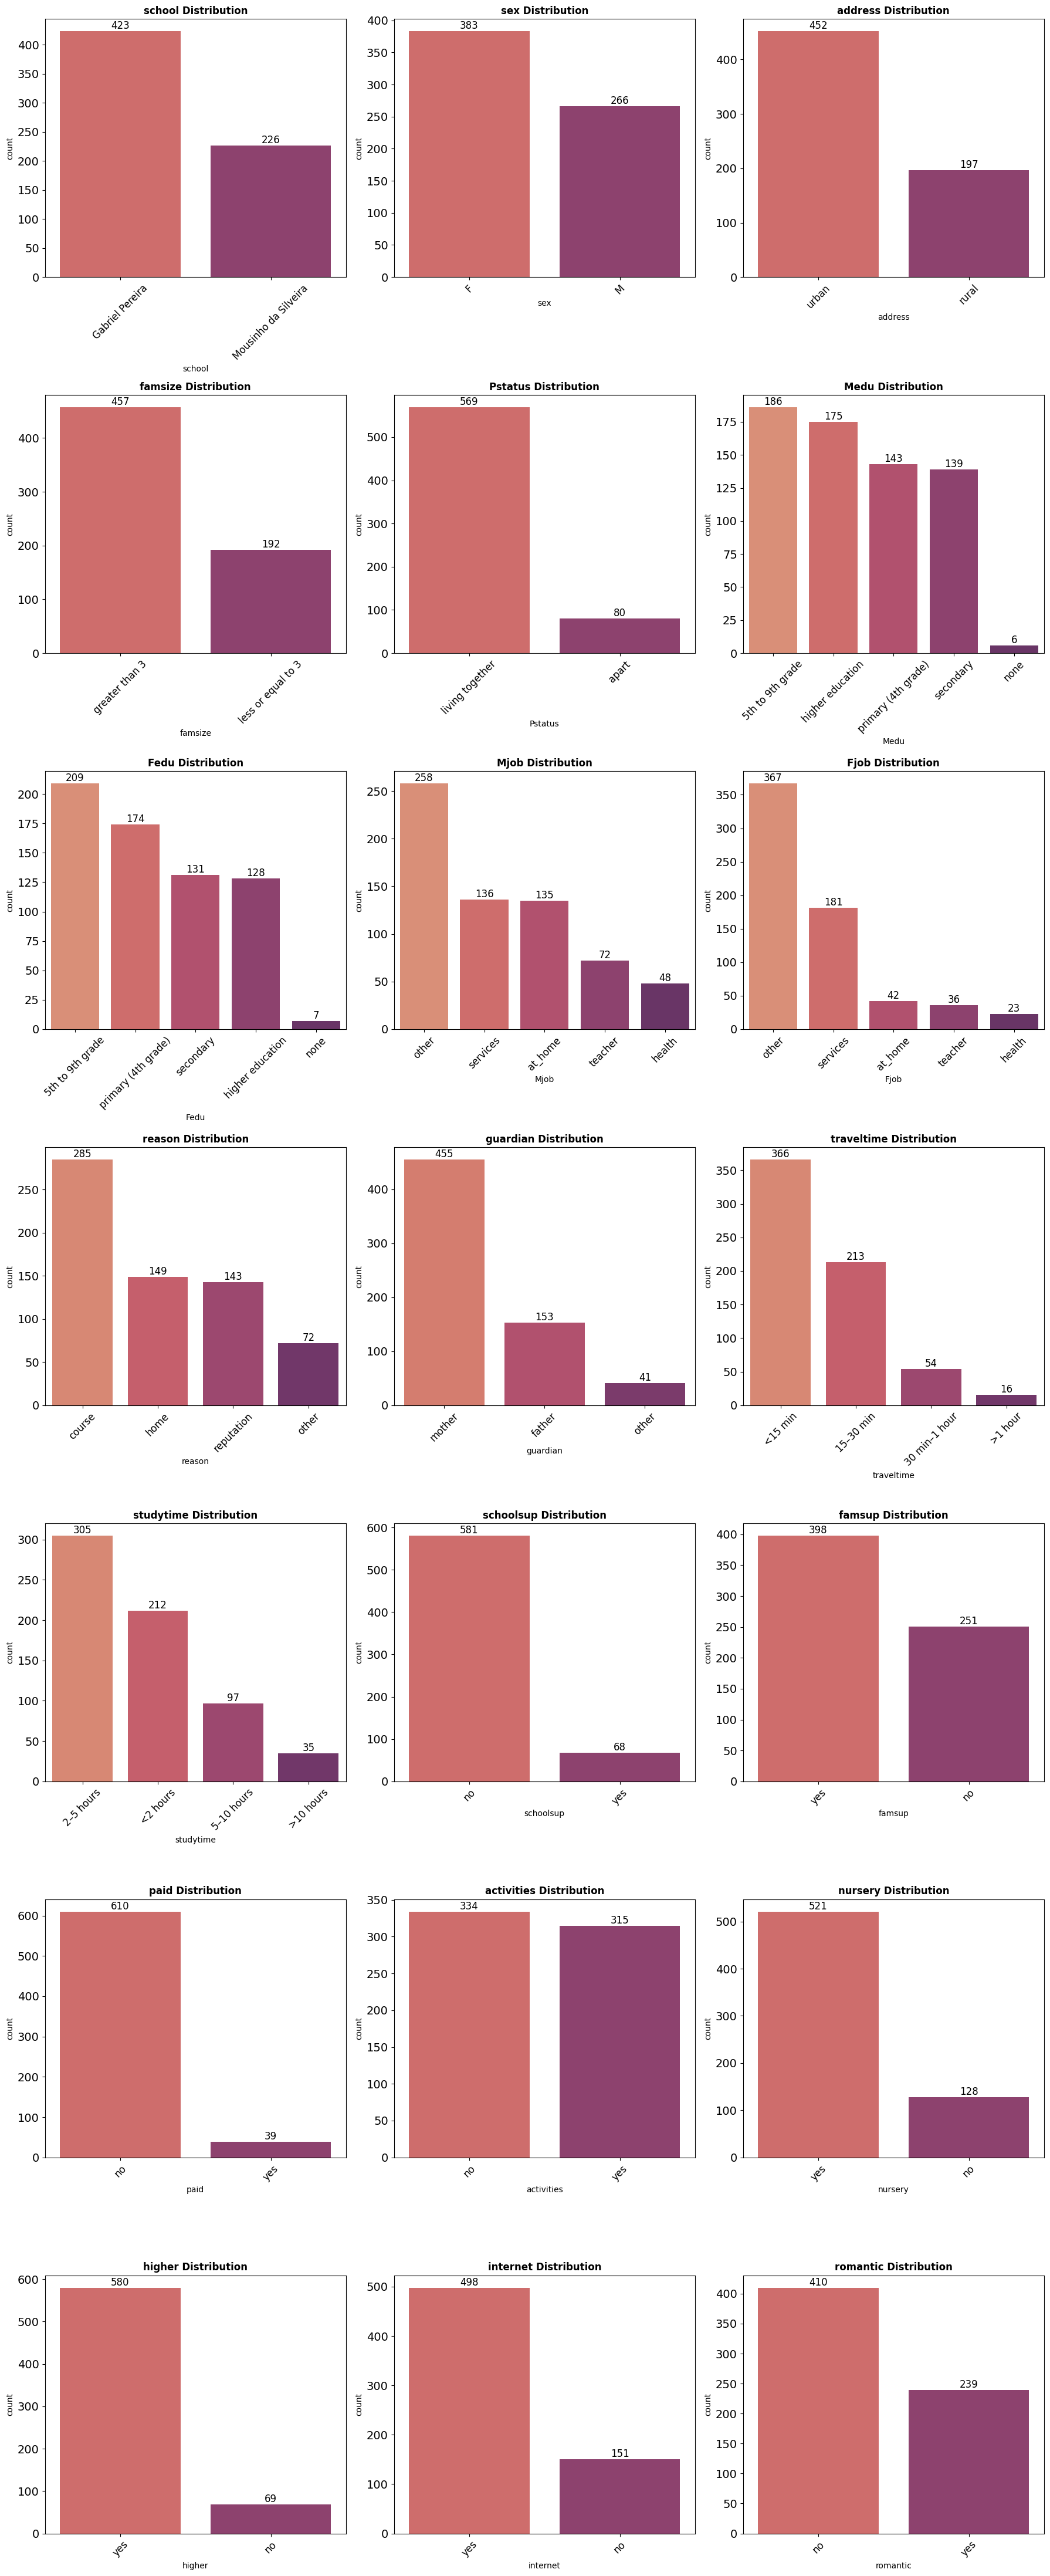

In [65]:
# Re-identify categorical columns after transformation
num_cols = full_df.select_dtypes(include='int64').columns
cat_cols = full_df.select_dtypes(include='object').columns

# Create bar charts for all categorical variables
fig, axes = plt.subplots(7, 3, figsize=(18, 44))
axes = axes.flatten()

for i, col_name in enumerate(cat_cols):
    ax = axes[i]
    sn.countplot(data=full_df, x=col_name, ax=ax, palette="flare", order=full_df[col_name].value_counts().index)
    ax.set_title(f"{col_name} Distribution", fontsize=12, fontweight='bold')
    ax.tick_params(axis='x', rotation=45, labelsize=12)
    ax.tick_params(axis='y', labelsize=14)
    
    # Add count labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', fontsize=12)

# Remove unused subplots
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Discussion on visual analysis of categorical features

From the bar plots above, it can be stated that the dataset suffers from pre-existing bias. Specifically, Rural students, students not seeking higher education, and students with separated parents are underrepresented as one category dominates in count over the others. When training a model (and subsequently auditing it for bias), class imbalance in categorical features can lead to poor performance on the minority groups.

#### Visualize Numerical Features Distribution

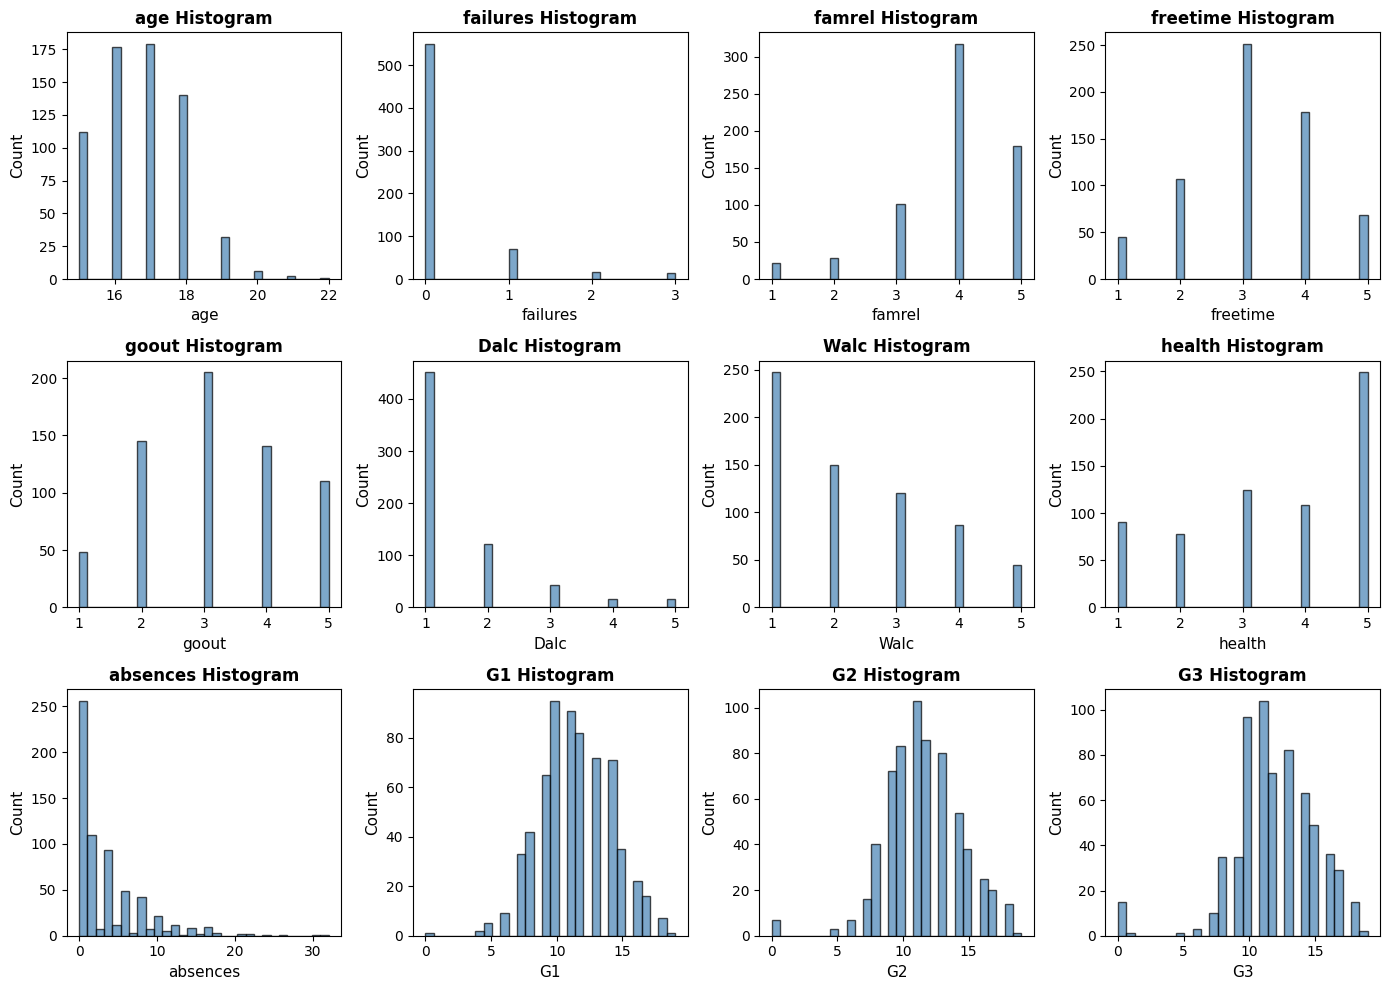

In [ ]:
# Create histograms for all numerical features
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    ax.hist(full_df[col], bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    ax.set_title(f"{col} Histogram", fontsize=12, fontweight='bold')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel("Count", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

# Remove unused subplots
for j in range(len(num_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### Discussion on visual analysis of numerical features

The histograms informs that while academic performance (G1,G2, and G3) generally follows a normal distribution, there is a critical anomaly of 0 score in the final term that might be speculated to represent dropouts from the school rather than poor performers. In contrast, self reported features such as health, and family relations are highly left-skewed which might also impact the learning of the model. 

#### Correlation Analysis of Numerical Features

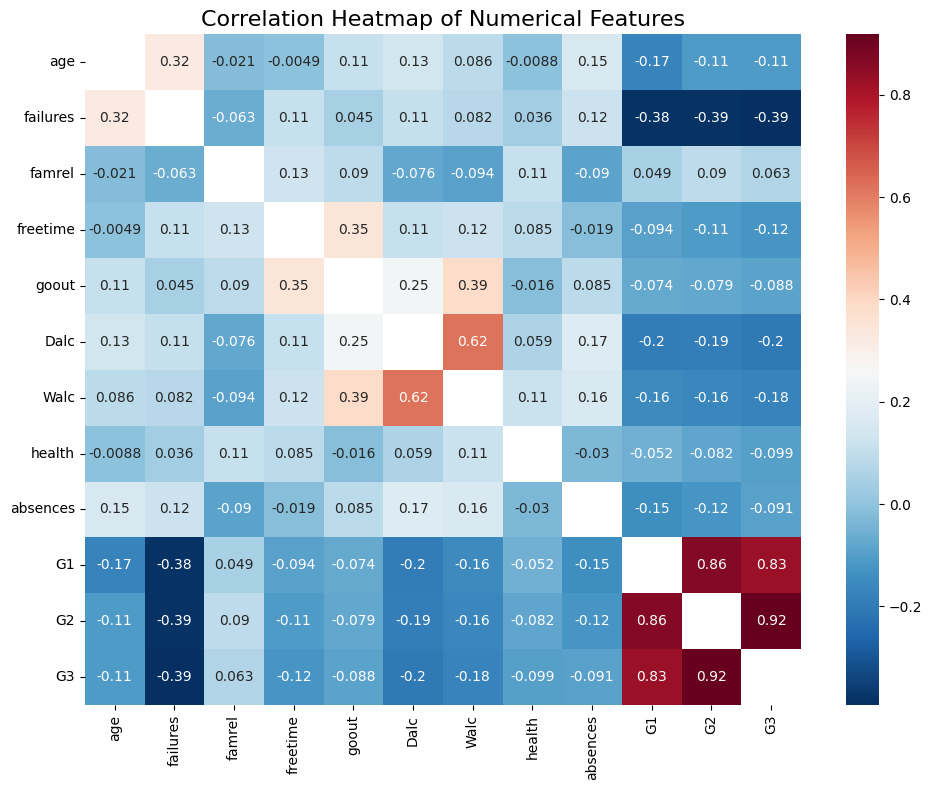

In [83]:
# Compute correlation matrix for numerical features
corr = full_df[num_cols].corr()

# Visualize correlations with heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(full_df[num_cols].corr(), mask=np.identity(len(full_df[num_cols].corr())), annot=True, cmap='RdBu_r')

plt.title("Correlation Heatmap of Numerical Features", fontsize=16)
plt.tight_layout()
plt.show()

##### Discussion on Correlation Analysis - 

## Output

## Appendix

* [1] https://archive.ics.uci.edu/dataset/320/student+performance
* [2] https://joshuagans.substack.com/p/the-covid-19-grading-mess
* [3] https://www.kaggle.com/code/mohamedsalahibrahim/student-performance
* [4] https://archive.ics.uci.edu/dataset/320/student+performance